# Analysing Spectral Energy Distribution and Emission/Absorption Visualization

<div class="alert alert-info">

**Note:** 

This notebook is only a sample demonstrating some of the features of the `sdecplotter` class. If you are interested in using additional features, you should directly access the [sdecplotter](https://github.com/tardis-sn/tardis/blob/master/tardis/visualization/tools/sdec_plot.py#L419) class. You can see the rest of the features of the sdecplotter class [here](docs/analysing_tardis_outputs/visualization/how_to_sdec_plot.ipynb).
</div>

A notebook for analyzing and visualizing the spectral energy distribution, emission and absorption patterns in supernova simulations using TARDIS.

In [1]:
import numpy as np
from astropy import units as u

from tardis.util.base import atomic_number2element_symbol
from tardis.visualization import plot_util as pu
from tardis.visualization.sdec.util import (
    calculate_absorption_luminosities,
    calculate_emission_luminosities,
)


/Users/wkerzend/python/tardis/tardis/__init__.py:24: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Every simulation run requires [atomic data](io/configuration/components/atomic/atomic_data.rst) and a [configuration file](io/configuration/index.rst). 

## Atomic Data

We recommend using the [kurucz_cd23_chianti_H_He_latest.h5](https://github.com/tardis-sn/tardis-regression-data/raw/main/atom_data/kurucz_cd23_chianti_H_He_latest.h5) dataset.

In [2]:
from tardis.io.atom_data import download_atom_data

# We download the atomic data needed to run the simulation
download_atom_data('kurucz_cd23_chianti_H_He_latest')

Atomic Data kurucz_cd23_chianti_H_He_latest already exists in /Users/wkerzend/projects/tardis/tardis-data/kurucz_cd23_chianti_H_He_latest.h5. Will not download - override with force_download=True.


## Example Configuration File

In [3]:
!wget -q -nc https://raw.githubusercontent.com/tardis-sn/tardis/master/docs/tardis_example.yml

In [4]:
!cat tardis_example.yml

# Example YAML configuration for TARDIS
tardis_config_version: v1.0

supernova:
  luminosity_requested: 9.44 log_lsun
  time_explosion: 13 day

atom_data: kurucz_cd23_chianti_H_He_latest.h5

model:
  structure:
    type: specific
    velocity:
      start: 1.1e4 km/s
      stop: 20000 km/s
      num: 20
    density:
      type: branch85_w7

  abundances:
    type: uniform
    O: 0.19
    Mg: 0.03
    Si: 0.52
    S: 0.19
    Ar: 0.04
    Ca: 0.03

plasma:
  disable_electron_scattering: no
  ionization: lte
  excitation: lte
  radiative_rates_type: dilute-blackbody
  line_interaction_type: macroatom

montecarlo:
  seed: 23111963
  no_of_packets: 4.0e+4
  iterations: 20
  nthreads: 1

  last_no_of_packets: 1.e+5
  no_of_virtual_packets: 10

  convergence_strategy:
    type: damped
    damping_constant: 1.0
    threshold: 0.05
    fraction: 0.8
    hold_iterations: 3
    t_inner:
      damping_constant: 0.5

spectrum:
  start: 500 angstrom
  stop: 20000 angstrom
  num: 10000


## Loading Simulation Data

### Running simulation

To run the simulation, import the `run_tardis` function and create the `sim` object.

<div class="alert alert-info">

**Note:**

Get more information about the [progress bars](io/output/progress_bars.rst), [logging configuration](io/optional/tutorial_logging_configuration.ipynb), and [convergence plots](io/visualization/tutorial_convergence_plot.ipynb).

</div>


In [5]:
from tardis import run_tardis

simulation = run_tardis(
    "tardis_example.yml",
    log_level="ERROR",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e1d69f87-af8d-4801-b6e5-6ad880664ea9': {'version…

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

### HDF

TARDIS can save simulation data to HDF files for later analysis. The code below shows how to load a simulation from an HDF file. This is useful when you want to analyze simulation results without re-running the simulation.


In [6]:
# import astropy.units as u
# import pandas as pd

# hdf_fpath = "add_file_path_here"
# with pd.HDFStore(hdf_fpath, "r") as hdf:
#     sim = u.Quantity(hdf["/simulation"])

## Calculating Spectral Quantities

This section demonstrates how to analyze the spectral decomposition (SDEC) output from TARDIS. SDEC helps understand how different atomic species contribute to the formation of spectral features through their emission and absorption processes.

### Wavelength and Frequency Grid Setup

First, we set up the wavelength and frequency grids for analysis and plotting

In [7]:
# Get frequency bins from the simulation's real packets spectrum
plot_frequency_bins = (
    simulation.spectrum_solver.spectrum_real_packets._frequency
)

# Get wavelength array from the simulation's real packets spectrum
plot_wavelength = simulation.spectrum_solver.spectrum_real_packets.wavelength

# Create frequency array by excluding the last bin edge
plot_frequency = plot_frequency_bins[:-1]

# Create a boolean mask array of ones with same size as wavelength array
# This will be used to filter wavelength ranges later
packet_wvl_range_mask = np.ones(plot_wavelength.size, dtype=bool)

### Luminosity Calculations

Then we calculate emission and absorption luminosities for each atomic species to understand their contributions to the spectrum


In [9]:
# Calculate emission luminosities for each species
# Returns a DataFrame with species-wise emission contributions and list of species
(emission_luminosities_df, emission_species) = calculate_emission_luminosities(
    simulation,
    "real",  # Use real packets mode
    packet_wvl_range=None,  # Use full wavelength range
)

# Calculate absorption luminosities for each species
# Returns a DataFrame with species-wise absorption contributions and list of species
(
    absorption_luminosities_df,
    absorption_species,
) = calculate_absorption_luminosities(
    simulation,
    packets_mode="real",  # Use real packets mode
    packet_wvl_range=None,  # Use full wavelength range
)

# Calculate total luminosities by adding absorption and emission
# Drop 'no interaction' and 'electron scattering' columns from emission before adding
total_luminosities_df = (
    absorption_luminosities_df
    + emission_luminosities_df.drop(["noint", "escatter"], axis=1)
)

# Convert atomic numbers to element symbols for plotting
species = np.array(list(total_luminosities_df.keys()))
species_name = [
    atomic_number2element_symbol(atomic_num)
    for atomic_num in species
]
species_length = len(species_name)

# Get the modeled spectrum luminosity for the selected wavelength range
modeled_spectrum_luminosity = (
    simulation.spectrum_solver.spectrum_real_packets.luminosity_density_lambda[
        packet_wvl_range_mask
    ]
)

## Plotting Species-wise Emission and Absorption Contributions

Now we will plot the species-wise emission and absorption contributions that we calculated in the previous step using calculate_emission_luminosities() and calculate_absorption_luminosities() respectively. We'll start with packets that had no interaction with the ejecta, followed by electron scattering events, and then contributions from different atomic species. The colorbar will help you to identify the atomic species and their respective contributions to the total luminosity at each wavelength.

### Matplotlib

<Axes: title={'center': 'TARDIS example Spectral Energy Distribution'}, xlabel='$\\text{Wavelength}\\,[\\mathrm{\\mathring{A}}]$', ylabel='$L_{\\lambda}\\,[\\mathrm{erg\\,s^{-1}\\,\\mathring{A}^{-1}}]$'>

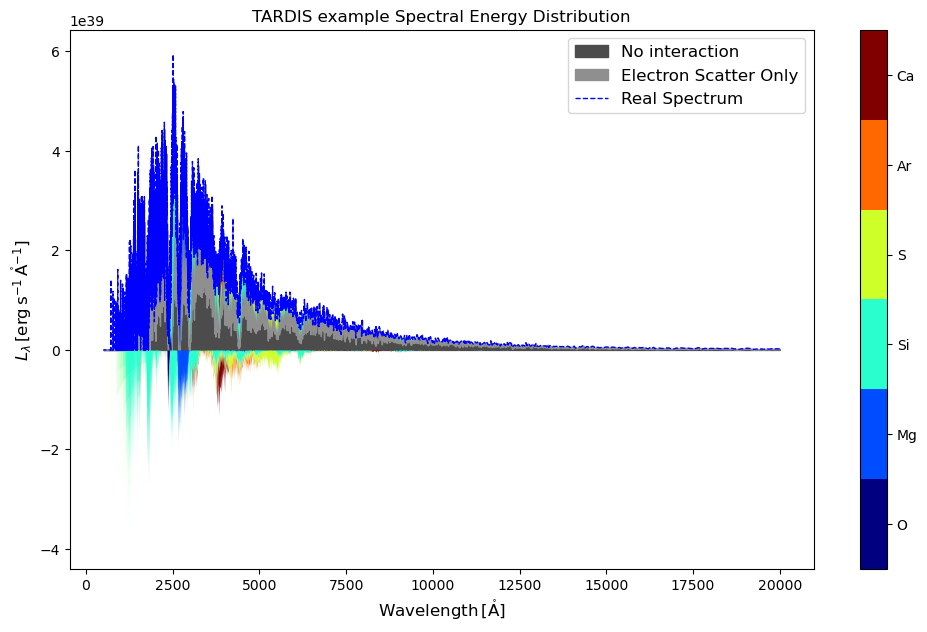

In [10]:
import matplotlib.cm as cm  # For colormaps
import matplotlib.colors as clr  # For color mapping and normalization
import matplotlib.pyplot as plt  # Main plotting interface

# Create figure and axis
ax = plt.figure(figsize=(12, 7)).add_subplot(111)

# Generate colors for each species using 'jet' colormap
# The colors will be evenly distributed across the colormap based on number of species
cmap = plt.get_cmap("jet", species_length)
color_list = []
color_values = []
for species_counter in range(species_length):
    # Calculate normalized color value and store in both lists
    color = cmap(species_counter / species_length)
    color_list.append(color)
    color_values.append(color)


# This will be used in the colorbar to show which color corresponds to which species
custcmap = clr.ListedColormap(color_values) # Normalize color range
norm = clr.Normalize(vmin=0, vmax=species_length)
mappable = cm.ScalarMappable(norm=norm, cmap=custcmap)
mappable.set_array(np.linspace(1, species_length + 1, 256))


# Add colorbar for species representation
cbar = plt.colorbar(mappable, ax=ax)
bounds = np.arange(species_length) + 0.5
cbar.set_ticks(bounds)
cbar.set_ticklabels(species_name) # Label ticks with species names

# Plot the emission contributions starting with 'no interaction' packets
lower_level = np.zeros(emission_luminosities_df.shape[0])  # Start at zero
upper_level = lower_level + emission_luminosities_df.noint.to_numpy()
ax.fill_between(
    plot_wavelength.value,
    lower_level,
    upper_level,
    color="#4C4C4C", #  Dark grey color
    label="No interaction",
)

# Plot electron scattering contribution
# This is stacked on top of the 'no interaction' contribution
lower_level = upper_level # Start where 'no interaction' ended
upper_level = lower_level + emission_luminosities_df.escatter.to_numpy()
ax.fill_between(
    plot_wavelength.value,
    lower_level,
    upper_level,
    color="#8F8F8F",
    label="Electron Scatter Only",
)

# Plot the emission contributions for each species by stacking them on top of each other.
# The lower level for each species starts where the previous species ended (upper_level),
# and the upper level adds that species' emission contribution.
# Each species gets a unique color from the colormap defined above.
for species_counter, identifier in enumerate(species):
    lower_level = upper_level
    upper_level = lower_level + emission_luminosities_df[identifier].to_numpy()

    ax.fill_between(
        plot_wavelength.value,
        lower_level,
        upper_level,
        color=color_list[species_counter],
        cmap=cmap,
        linewidth=0,
    )


# The absorption contributions are plotted below zero, showing how each species
# absorbs light and reduces the total luminosity. The contributions are stacked
# downward from zero, with each species getting the same color as its emission above.
lower_level = np.zeros(absorption_luminosities_df.shape[0])
for species_counter, identifier in enumerate(species):
    upper_level = lower_level
    lower_level = (
        upper_level - absorption_luminosities_df[identifier].to_numpy()
    )

    ax.fill_between(
        plot_wavelength.value,
        upper_level,
        lower_level,
        color=color_list[species_counter],
        cmap=cmap,
        linewidth=0,
    )


# Plot the modeled spectrum
ax.plot(
    plot_wavelength.value,
    modeled_spectrum_luminosity.value,
    "--b",
    label="Real Spectrum",
    linewidth=1,
)
xlabel = pu.axis_label_in_latex("Wavelength", u.AA)
ylabel = pu.axis_label_in_latex(
    "L_{\\lambda}", u.Unit("erg/(s AA)"), only_text=False
)
# Add labels, legend, and formatting
ax.set_title("TARDIS example Spectral Energy Distribution")
ax.legend(fontsize=12)
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)

plt.gca()

### Plotly

In [14]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# By specifying a common stackgroup, plotly will itself add up luminosities,
# in order, to created stacked area chart
fig.add_trace(
    go.Scatter(
        x=emission_luminosities_df.index,
        y=emission_luminosities_df.noint,
        mode="none",
        name="No interaction",
        fillcolor="#4C4C4C",
        stackgroup="emission",
        hovertemplate="(%{x:.2f}, %{y:.3g})",
    )
)

fig.add_trace(
    go.Scatter(
        x=emission_luminosities_df.index,
        y=emission_luminosities_df.escatter,
        mode="none",
        name="Electron Scatter Only",
        fillcolor="#8F8F8F",
        stackgroup="emission",
        hoverlabel={"namelength": -1},
        hovertemplate="(%{x:.2f}, %{y:.3g})",
    )
)

# The species data comes from the emission_luminosities_df and absorption_luminosities_df DataFrames
# We plot emissions as positive values stacked above zero
# And absorptions as negative values stacked below zero
# This creates a visualization showing how different species contribute to the spectrum
for (species_counter, identifier), name_of_spec in zip(
    enumerate(species), species_name
):
    fig.add_trace(
        go.Scatter(
            x=emission_luminosities_df.index,
            y=emission_luminosities_df[identifier],
            mode="none",
            name=name_of_spec + " Emission",
            hovertemplate=f"<b>{name_of_spec:s} Emission<br>"  # noqa: ISC003
            + "(%{x:.2f}, %{y:.3g})<extra></extra>",
            fillcolor=pu.to_rgb255_string(color_list[species_counter]),
            stackgroup="emission",
            showlegend=False,
            hoverlabel={"namelength": -1},
        )
    )
    # Plot absorption part
    fig.add_trace(
        go.Scatter(
            x=absorption_luminosities_df.index,
            # to plot absorption luminosities along negative y-axis
            y=absorption_luminosities_df[identifier] * -1,
            mode="none",
            name=name_of_spec + " Absorption",
            hovertemplate=f"<b>{name_of_spec:s} Absorption<br>"  # noqa: ISC003
            + "(%{x:.2f}, %{y:.3g})<extra></extra>",
            fillcolor=pu.to_rgb255_string(color_list[species_counter]),
            stackgroup="absorption",
            showlegend=False,
            hoverlabel={"namelength": -1},
        )
    )

# Plot modeled spectrum
fig.add_trace(
    go.Scatter(
        x=plot_wavelength.value,
        y=modeled_spectrum_luminosity.value,
        mode="lines",
        line={
            "color": "blue",
            "width": 1,
        },
        name="Real Spectrum",
        hovertemplate="(%{x:.2f}, %{y:.3g})",
        hoverlabel={"namelength": -1},
    )
)

# Interpolate [0, 1] range to create bins equal to number of elements
colorscale_bins = np.linspace(0, 1, num=len(species_name) + 1)

# Create a categorical colorscale [a list of (reference point, color)]
# by mapping same reference points (excluding 1st and last bin edge)
# twice in a row (https://plotly.com/python/colorscales/#constructing-a-discrete-or-discontinuous-color-scale)
categorical_colorscale = []
for species_counter in range(len(species_name)):
    color = pu.to_rgb255_string(cmap(colorscale_bins[species_counter]))
    categorical_colorscale.append((colorscale_bins[species_counter], color))
    categorical_colorscale.append((colorscale_bins[species_counter + 1], color))

# Create a categorical colorscale for the elements by mapping each species to a color
coloraxis_options = {
    "colorscale": categorical_colorscale,
    "showscale": True,
    "cmin": 0,
    "cmax": len(species_name),
    "colorbar": {
        "title": "Elements",
        "tickvals": np.arange(0, len(species_name)) + 0.5,
        "ticktext": species_name,
        # to change length and position of colorbar
        "len": 0.75,
        "yanchor": "top",
        "y": 0.75,
    },
}

# Add an invisible scatter point to make the colorbar show up in the plot
# The point is placed at the middle of the wavelength range with y=0
# The marker color is set to 0 (first color in colorscale) with opacity=0 to hide it
# coloraxis_options contains the categorical colorscale mapping species to colors
scatter_point_idx = pu.get_mid_point_idx(plot_wavelength)
fig.add_trace(
    go.Scatter(
        x=[plot_wavelength[scatter_point_idx].value],
        y=[0],
        mode="markers",
        name="Colorbar",
        showlegend=False,
        hoverinfo="skip",
        marker=dict(color=[0], opacity=0, **coloraxis_options),
    )
)

# Set label and other layout options
xlabel = pu.axis_label_in_latex("Wavelength", u.AA)
ylabel = pu.axis_label_in_latex(
    "L_{\\lambda}", u.Unit("erg/(s AA)"), only_text=False
)
fig.update_layout(
    title="TARDIS example Spectral Energy Distribution ",
    xaxis={
        "title": xlabel,
        "exponentformat": "none",
    },
    yaxis={"title": ylabel, "exponentformat": "e"},
    xaxis_range=[0, 9000],
    height=600,
)

fig.show(renderer='notebook_connected')